In [ ]:
import warnings

# Suppress the Deprecation Warnings.
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load in the necessary libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from xgboost import XGBClassifier

In [2]:
# Load in the dataset.
df_train = pd.read_csv('Resources/train.csv')
df_val = pd.read_csv('Resources/valid.csv')
df_test = pd.read_csv('Resources/X_test.csv')

In [3]:
# Get a general overview of the dataset.
display(df_train.head())
display(df_train.shape)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
0,NaN,NaN,14000,14000,14000.0,36 months,7.35,434.53,A,A4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,2000,2000,2000.0,36 months,16.29,70.61,D,D2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,5000,5000,4750.0,36 months,7.39,155.28,A,A4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,20600,20600,20600.0,36 months,11.99,684.12,B,B5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,10000,10000,10000.0,36 months,7.39,310.56,A,A4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1


(517788, 145)

## Handling Missing Values


In [4]:
# Drop the columns where more than 50% of the data is missing.
df_train.dropna(axis='columns', inplace=True, thresh=len(df_train)/2)

print(df_train.shape)

(517788, 87)


## Detecting and Removing Outliers


In [5]:
display(df_train.select_dtypes(include=['int64', 'float64']).columns)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_t

<Axes: xlabel='int_rate'>

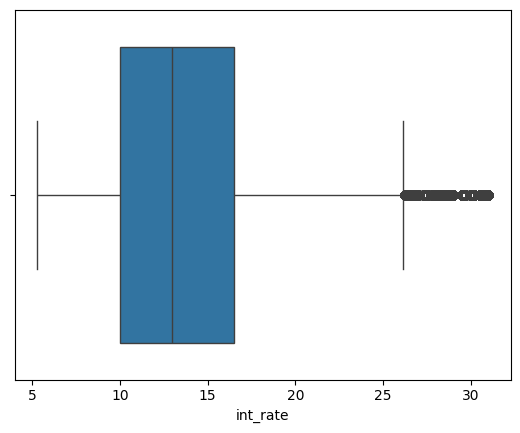

In [6]:
# The business context should govern how we define and react to outliers.
# The meanings of our findings should be dictated by the underlying context, rather than the number itself.

sns.boxplot(x=df_train['int_rate'])

## Feature Encoding


In [7]:
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()

# Display the categorical columns.
display(df_train.select_dtypes(include=['object']).columns)


def encode_cat_cols(df):
    df['term'] = df['term'].map({'60 months': 0, '36 months': 1})

    mapping_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
    df['grade'] = df['grade'].map(mapping_dict)

    mapping_dict = {
        'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4,
        'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9,
        'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14,
        'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19,
        'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24,
        'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29,
        'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34
    }
    df['sub_grade'] = df['sub_grade'].map(mapping_dict)

    df['emp_title'] = df['emp_title'].str.lower()
    df['emp_title'] = label_encoder.fit_transform(df['emp_title'])

    df['emp_length'] = df['emp_length'].str.replace(' years?', '', regex=True)
    mapping_dict = {'< 1': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10+': 10}
    df['emp_length'] = df['emp_length'].map(mapping_dict).fillna(0).astype(int)

    mapping_dict = {'OWN': 0, 'RENT': 1, 'MORTGAGE': 2, 'ANY': 4, 'OTHER': 4, 'NONE': 4}
    df['home_ownership'] = df['home_ownership'].map(mapping_dict)

    mapping_dict = {'Verified': 0, 'Source Verified': 1, 'Not Verified': 2}
    df['verification_status'] = df['verification_status'].map(mapping_dict)

    df[['issue_m', 'issue_y']] = df['issue_d'].str.split('-', expand=True)
    mapping_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df['issue_m'] = df['issue_m'].map(mapping_dict)
    df['issue_m'] = df['issue_m'].astype(int)
    df['issue_y'] = df['issue_y'].astype(int)
    df.drop(columns='issue_d', inplace=True)

    mapping_dict = {'y': 0, 'n': 1}
    df['pymnt_plan'] = df['pymnt_plan'].map(mapping_dict)

    df['purpose'] = label_encoder.fit_transform(df['purpose'])

    df['title'] = df['title'].str.lower()
    df['title'] = label_encoder.fit_transform(df['title'])

    df['zip_code'] = df['zip_code'].str.lower()
    df['zip_code'] = label_encoder.fit_transform(df['zip_code'])

    df['addr_state'] = label_encoder.fit_transform(df['addr_state'])

    df[['earliest_cr_m', 'earliest_cr_y']] = df['earliest_cr_line'].str.split('-', expand=True)
    mapping_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df['earliest_cr_m'] = df['earliest_cr_m'].map(mapping_dict)
    df['earliest_cr_m'] = df['earliest_cr_m'].astype(int)
    df['earliest_cr_y'] = df['earliest_cr_y'].astype(int)
    df.drop(columns='earliest_cr_line', inplace=True)

    mapping_dict = {'f': 0, 'w': 1}
    df['initial_list_status'] = df['initial_list_status'].map(mapping_dict)

    df[['last_pymnt_m', 'last_pymnt_y']] = df['last_pymnt_d'].str.split('-', expand=True)
    mapping_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df['last_pymnt_m'] = df['last_pymnt_m'].map(mapping_dict)
    df['last_pymnt_m'] = df['last_pymnt_m'].fillna(99)
    df['last_pymnt_y'] = df['last_pymnt_y'].fillna('9999')
    df['last_pymnt_m'] = df['last_pymnt_m'].astype(int)
    df['last_pymnt_y'] = df['last_pymnt_y'].astype(int)
    df.drop(columns='last_pymnt_d', inplace=True)

    df[['last_credit_pull_m', 'last_credit_pull_y']] = df['last_credit_pull_d'].str.split('-', expand=True)
    mapping_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df['last_credit_pull_m'] = df['last_credit_pull_m'].map(mapping_dict)
    df['last_credit_pull_m'] = df['last_credit_pull_m'].fillna(0)
    df['last_credit_pull_y'] = df['last_credit_pull_y'].fillna('0000')
    df['last_credit_pull_m'] = df['last_credit_pull_m'].astype(int)
    df['last_credit_pull_y'] = df['last_credit_pull_y'].astype(int)
    df.drop(columns='last_credit_pull_d', inplace=True)

    mapping_dict = {'Joint App': 0, 'Individual': 1}
    df['application_type'] = df['application_type'].map(mapping_dict)

    mapping_dict = {'N': 0, 'Y': 1}
    df['hardship_flag'] = df['hardship_flag'].map(mapping_dict)

    mapping_dict = {'DirectPay': 0, 'Cash': 1}
    df['disbursement_method'] = df['disbursement_method'].map(mapping_dict)

    mapping_dict = {'Y': 0, 'N': 1}
    df['debt_settlement_flag'] = df['debt_settlement_flag'].map(mapping_dict)

    return df


encode_cat_cols(df_train)
encode_cat_cols(df_val)
encode_cat_cols(df_test)

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d',
       'application_type', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,settlement_percentage,settlement_term,issue_m,issue_y,earliest_cr_m,earliest_cr_y,last_pymnt_m,last_pymnt_y,last_credit_pull_m,last_credit_pull_y
0,NaN,NaN,8100,8100,8100.0,0,11.47,267.00,1,9,...,NaN,NaN,3,2016,3,2010,4,2016,5,2018
1,NaN,NaN,10000,10000,10000.0,0,12.99,336.90,2,11,...,NaN,NaN,5,2016,9,2005,9,2016,2,2017
2,NaN,NaN,9450,9450,9450.0,0,13.67,321.47,1,9,...,NaN,NaN,11,2013,8,1998,8,2014,5,2018
3,NaN,NaN,25000,25000,24975.0,0,17.49,897.43,3,19,...,NaN,NaN,6,2011,11,1990,6,2014,6,2014
4,NaN,NaN,16000,16000,16000.0,1,14.99,380.56,2,14,...,NaN,NaN,2,2015,6,2001,7,2017,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172591,NaN,NaN,7000,7000,7000.0,0,18.25,253.95,4,20,...,NaN,NaN,5,2015,4,2012,11,2016,2,2019
172592,NaN,NaN,12500,12500,12500.0,0,12.49,418.12,1,9,...,NaN,NaN,8,2014,9,2006,1,2016,1,2019
172593,NaN,NaN,30000,30000,30000.0,0,7.89,938.57,0,4,...,NaN,NaN,6,2015,1,1999,7,2018,11,2018
172594,NaN,NaN,3500,3500,3500.0,0,8.59,110.64,0,4,...,NaN,NaN,7,2016,10,2004,12,2017,2,2019


## Feature Scaling


In [8]:
def scale_features(df):
    # Scale numerical columns using MinMaxScaler, excluding the target column if it exists.
    scaler = MinMaxScaler()

    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    if 'loan_status' in numerical_columns:
        numerical_columns = numerical_columns.drop('loan_status')
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


scale_features(df_train)
scale_features(df_val)
scale_features(df_test)

/home/dulina-perera/anaconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/home/dulina-perera/anaconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/home/dulina-perera/anaconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/home/dulina-perera/anaconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [10]:
def train_xgboost_classifier(df_train, features, target):
    # Initialize XGBoost classifier
    xgb_classifier = XGBClassifier()

    # Train the classifier on the entire dataset
    xgb_classifier.fit(df_train[features], df_train[target])

    return xgb_classifier


def select_features(df_train, target, feature_importance_threshold=0.01):
    # Initialize XGBoost classifier for feature selection
    xgb_classifier = XGBClassifier()

    # Train the classifier to select features based on importance scores
    selector = SelectFromModel(xgb_classifier, threshold=feature_importance_threshold)
    selector.fit(df_train.drop(target, axis=1), df_train[target])

    # Get selected feature indices
    selected_feature_indices = selector.get_support(indices=True)

    # Get selected feature names
    selected_features = df_train.drop(target, axis=1).columns[selected_feature_indices]

    return selected_features


def evaluate_model(model, X, y):
    # Predict on the dataset
    y_pred = model.predict(X)

    # Evaluate the model
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy:", accuracy)

    return accuracy


def save_predictions(df, selected_features, model, output_file='test.csv'):
    # Subset the DataFrame with selected features
    X_selected = df[selected_features]

    # Predict on the dataset
    y_pred = model.predict(X_selected)

    # Create a new DataFrame with selected features and predicted target variable
    df_with_predictions = X_selected.copy()
    df_with_predictions['loan_status'] = y_pred

    # Rearrange columns to have 'loan_status' as the first column
    df_with_predictions = df_with_predictions[['loan_status'] + list(X_selected.columns)]

    # Save the DataFrame to a new CSV file
    df_with_predictions.to_csv(output_file, index=False)


# Define the target variable
target = 'loan_status'

# Select features based on importance scores
selected_features = select_features(df_train, target)
display(selected_features)

# Train XGBoost classifier
model = train_xgboost_classifier(df_train, pd.Index(['term', 'last_pymnt_amnt', 'funded_amnt', 'total_rec_prncp']), target)

# Evaluate the model on validation set
# evaluate_model(model, df_val[selected_features], df_val[target])
evaluate_model(model, df_val[pd.Index(['term', 'last_pymnt_amnt', 'funded_amnt', 'total_rec_prncp'])], df_val[target])

# Save predictions on test set
save_predictions(df_test, pd.Index(['term', 'last_pymnt_amnt', 'funded_amnt', 'total_rec_prncp']), model)

Index(['funded_amnt', 'term', 'total_rec_prncp', 'recoveries',
       'last_pymnt_amnt'],
      dtype='object')

Accuracy: 0.9994785510672322
